In [1]:
# 自动重载模块（修改 .py 文件后自动生效）
%load_ext autoreload
%autoreload 2
from typing import Dict, List, Optional, Tuple

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import talib as ta
# 导入自定义模块
from pipeline.trading_pipeline import TradingPipeline

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✅ 环境配置完成")


✅ 环境配置完成


In [10]:
df = pd.read_feather('/Volumes/Ext-Disk/data/futures/um/ETHUSDT/bars_with_features-2025-01-01-2025-01-20-1h.feather')
df[['start_time', 'end_time']]
df.head(5)

,open,high,low,close,volume,dollar_value,taker_buy_volume,maker_buy_volume,start_trade_idx,end_trade_idx,trades,end_time,start_time,cs_qty,cs_quote,cs_signed_qty,cs_signed_quote,cs_pxqty,cs_ret2,cs_abs_r,cs_bpv,bar_id,large_abs_100_dollar_sum,large_abs_100_count,large_abs_100_buy_dollar,large_abs_100_sell_dollar,large_abs_100_buy_count,large_abs_100_sell_count,large_abs_1000_dollar_sum,large_abs_1000_count,large_abs_1000_buy_dollar,large_abs_1000_sell_dollar,large_abs_1000_buy_count,large_abs_1000_sell_count,large_abs_10000_dollar_sum,large_abs_10000_count,large_abs_10000_buy_dollar,large_abs_10000_sell_dollar,large_abs_10000_buy_count,large_abs_10000_sell_count,large_abs_100000_dollar_sum,large_abs_100000_count,large_abs_100000_buy_dollar,large_abs_100000_sell_dollar,large_abs_100000_buy_count,large_abs_100000_sell_count,bar_logret,bar_abs_logret,bar_logret2,bar_logret4,bar_log_hl,bar_parkinson_var,bar_gk_var,bar_rs_var,bar_tr,bar_tr_norm,bar_duration_s,bar_intensity_trade_per_s,bar_dollar_per_s,bar_amihud,cs_bar_logret,cs_bar_abs_logret,cs_bar_logret2,cs_bar_logret4,cs_bar_tr,cs_bar_log_hl,cs_bar_parkinson_var,cs_bar_gk_var,cs_bar_rs_var,cs_bar_duration_s,cs_dollar_value,cs_volume,cs_trades,cs_large_abs_100_dollar_sum,cs_large_abs_100_count,cs_large_abs_100_buy_dollar,cs_large_abs_100_sell_dollar,cs_large_abs_100_buy_count,cs_large_abs_100_sell_count,cs_large_abs_1000_dollar_sum,cs_large_abs_1000_count,cs_large_abs_1000_buy_dollar,cs_large_abs_1000_sell_dollar,cs_large_abs_1000_buy_count,cs_large_abs_1000_sell_count,cs_large_abs_10000_dollar_sum,cs_large_abs_10000_count,cs_large_abs_10000_buy_dollar,cs_large_abs_10000_sell_dollar,cs_large_abs_10000_buy_count,cs_large_abs_10000_sell_count,cs_large_abs_100000_dollar_sum,cs_large_abs_100000_count,cs_large_abs_100000_buy_dollar,cs_large_abs_100000_sell_dollar,cs_large_abs_100000_buy_count,cs_large_abs_100000_sell_count,bar_ofi_signed_qty_sum,bar_ofi_signed_quote_sum,bar_gof_by_count,bar_gof_by_volume,bar_rv,bar_bpv,bar_jump_rv_bpv,bar_micro_dp_short,bar_micro_dp_zscore,bar_hl_amplitude_ratio
0,3336.58,3364.50,3334.76,3362.90,68327.229,2.290786e+08,41887.238,26439.991,0,128258,128259,2025-01-01 01:00:00,2025-01-01 00:00:00,68327.229,2.290786e+08,15447.247,5.179288e+07,2.290786e+08,0.000021,0.537372,0.000007,0,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0,NaN,NaN,NaN,NaN,0.008879,0.000028,0.000016,0.000009,29.74,0.008844,3600.0,35.627500,63632.938150,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,29.74,0.008879,0.000028,0.000016,0.000009,3600.0,2.290786e+08,68327.229,128259,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0,15447.247,5.179288e+07,0.169976,0.226077,0.000019,0.000010,0.000009,0.000000,0.577350,0.008879
1,3362.89,3365.32,3341.18,3345.82,40083.238,1.344243e+08,18969.926,21113.312,128259,224930,96672,2025-01-01 02:00:00,2025-01-01 01:00:00,108410.467,3.635029e+08,13303.861,4.459589e+07,3.635029e+08,0.000033,0.908327,0.000012,1,1.325398e+08,39251.0,6.269638e+07,6.984337e+07,18665.0,20586.0,1.250283e+08,17874.0,5.897554e+07,6.605280e+07,7698.0,10176.0,7.854097e+07,3230.0,3.855452e+07,3.998645e+07,1588.0,1642.0,6.736553e+06,30.0,2.546910e+06,4.189643e+06,16.0,14.0,-0.005092,0.005092,0.000026,6.722279e-10,0.007199,0.000019,0.000016,0.000013,24.14,0.007215,3600.0,26.853333,37340.093283,3.787924e-11,-0.005092,0.005092,0.000026,6.722279e-10,53.88,0.016078,0.000047,0.000031,0.000022,7200.0,3.635029e+08,108410.467,224931,3.592145e+08,93769.0,2.017224e+08,1.574920e+08,51912.0,41857.0,3.413636e+08,43912.0,1.916666e+08,1.496970e+08,22982.0,20930.0,2.277584e+08,8661.0,1.313440e+08,9.641439e+07,4841

In [10]:
# ============ 配置参数 ============
# 特征配置
feature_config = {
    'basic': False,
    'orderflow': False,
    'impact': False,
    'volatility': False,
    'path_shape': False,
    'tail': True,
}

# 模型配置
model_config = {
    'random_state': 42
}

# 数据配置
start_date = '2025-01-01'
end_date = '2025-01-30'

# Bar 配置
bar_type = 'time'  # 'dollar' 或 'time'
time_interval = '1h'  # 仅当 bar_type='time' 时有效
dollar_threshold = 10000 * 60000  # 仅当 bar_type='dollar' 时有效

# 文件路径配置
# 原始数据路径配置
data_base_path = '/Volumes/Ext-Disk/data/futures/um'
daily_data_template = f'{data_base_path}/daily/trades/ETHUSDT/ETHUSDT-trades-{{date}}.{{ext}}'
monthly_data_template = f'{data_base_path}/monthly/trades/ETHUSDT/ETHUSDT-trades-{{month}}.{{ext}}'

# Bars 缓存路径（放在 output 目录）
output_base_path = '/Users/aming/project/python/crypto-trade/output'
plot_save_dir = '/Users/aming/project/python/crypto-trade/strategy/fusion/pic'

# 根据 bar_type 生成 bars 缓存文件路径
if bar_type == 'time':
    cache_key = f'{start_date}-{end_date}-{time_interval}'
else:
    dollar_threshold_str = str(dollar_threshold).replace("*", "_")
    cache_key = f'{start_date}-{end_date}-{dollar_threshold_str}'

bar_cache_template = f'{output_base_path}/bars-{cache_key}.{{ext}}'

# 训练配置
feature_window_bars = 24  # 用于特征提取的历史 bar 数量
model_type = 'linear'  # 'ridge', 'linear', 'lgbm' 等
target_horizon = 5  # 预测的未来 bar 数量
n_splits = 5  # 交叉验证折数
embargo_bars = 3  # 禁运期（避免数据泄漏）


In [11]:
# 创建 Pipeline 实例
horizon_bars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
config = {
    'features': feature_config,
    'model': model_config,
    'labels': {
        'horizon_bars': horizon_bars  # 自定义预测持有期
    },
    'data': {
        'load_mode': 'monthly',  # 'daily', 'monthly', 'auto'（自动选择最优）
        'prefer_feather': True  # 优先使用 feather 格式
    }
}

pipeline = TradingPipeline(config)
print("✅ Pipeline 实例创建成功")


✅ Pipeline 实例创建成功


In [12]:
# 加载交易数据
trades_df = pipeline.load_data(
    date_range=(start_date, end_date),
    daily_data_template=daily_data_template,
    monthly_data_template=monthly_data_template
)

# print(f"\n✅ 成功加载 {len(trades_df):,} 条交易记录")
# print(f"   时间范围: {trades_df['timestamp'].min()} ~ {trades_df['timestamp'].max()}")
# print(f"   数据形状: {trades_df.shape}")
# print("\n前5行数据:")
trades_df.head()


📂 按月加载数据: 2025-01-01 到 2025-01-30 (1 个月)
   ✓ 加载 2025-01 (feather)
✅ 加载了 1 个月度文件，开始合并...


,id,price,qty,quote_qty,time,is_buyer_maker
0,4936628773,3336.58,6.583,21964.70614,1735689605058,False
1,4936628774,3336.57,0.033,110.10681,1735689605064,True
2,4936628775,3336.58,1.135,3787.01830,1735689605072,False
3,4936628776,3336.57,0.460,1534.82220,1735689605079,True
4,4936628777,3336.57,0.231,770.74767,1735689605079,True


In [11]:
len(trades_df)

154747884

In [6]:
# 查看交易数据的基本统计信息
print("交易数据统计:")
print(trades_df.describe())


交易数据统计:
                 id         price           qty     quote_qty          time
count  1.547479e+08  1.547479e+08  1.547479e+08  1.547479e+08  1.547479e+08
mean   5.014020e+09  3.308612e+03  6.239437e-01  2.059502e+03  1.737106e+12
std    4.468077e+07  1.425731e+02  4.736901e+00  1.385365e+04  7.171676e+08
min    4.936629e+09  2.900000e+03  1.000000e-03  1.024177e+00  1.735690e+12
25%    4.975325e+09  3.224780e+03  7.000000e-03  2.331350e+01  1.736487e+12
50%    5.014023e+09  3.296150e+03  2.000000e-02  6.714070e+01  1.737192e+12
75%    5.052715e+09  3.370420e+03  2.540000e-01  8.458688e+02  1.737653e+12
max    5.091406e+09  3.744280e+03  7.958862e+03  1.000000e+07  1.738368e+12


In [13]:
# 构建 Bars
bars = pipeline.build_bars(
    trades_df,
    dollar_threshold=dollar_threshold,
    bar_cache_template=bar_cache_template,
    bar_type=bar_type,
    time_freq=time_interval if bar_type == 'time' else None
)

# print(f"\n✅ 成功构建 {len(bars):,} 个 {bar_type.upper()} Bars")
# print(f"   时间范围: {bars['start_time'].min()} ~ {bars['end_time'].max()}")
# print(f"   数据形状: {bars.shape}")
# print("\n前5个Bars:")
bars.head()


✓ 从 Feather 缓存加载 bars: /Users/aming/project/python/crypto-trade/output/bars-2025-01-01-2025-01-30-1h.feather


,open,high,low,close,volume,dollar_value,taker_buy_volume,maker_buy_volume,start_trade_idx,end_trade_idx,trades,end_time,start_time,cs_qty,cs_quote,cs_signed_qty,cs_signed_quote,cs_pxqty,cs_ret2,cs_abs_r,cs_bpv,bar_id,large_abs_100_dollar_sum,large_abs_100_count,large_abs_100_buy_dollar,large_abs_100_sell_dollar,large_abs_100_buy_count,large_abs_100_sell_count,large_abs_1000_dollar_sum,large_abs_1000_count,large_abs_1000_buy_dollar,large_abs_1000_sell_dollar,large_abs_1000_buy_count,large_abs_1000_sell_count,large_abs_10000_dollar_sum,large_abs_10000_count,large_abs_10000_buy_dollar,large_abs_10000_sell_dollar,large_abs_10000_buy_count,large_abs_10000_sell_count,large_abs_100000_dollar_sum,large_abs_100000_count,large_abs_100000_buy_dollar,large_abs_100000_sell_dollar,large_abs_100000_buy_count,large_abs_100000_sell_count,bar_logret,bar_abs_logret,bar_logret2,bar_logret4,bar_log_hl,bar_parkinson_var,bar_gk_var,bar_rs_var,bar_tr,bar_tr_norm,bar_duration_s,bar_intensity_trade_per_s,bar_dollar_per_s,bar_amihud,cs_bar_logret,cs_bar_abs_logret,cs_bar_logret2,cs_bar_logret4,cs_bar_tr,cs_bar_log_hl,cs_bar_parkinson_var,cs_bar_gk_var,cs_bar_rs_var,cs_bar_duration_s,cs_dollar_value,cs_volume,cs_trades,cs_large_abs_100_dollar_sum,cs_large_abs_100_count,cs_large_abs_100_buy_dollar,cs_large_abs_100_sell_dollar,cs_large_abs_100_buy_count,cs_large_abs_100_sell_count,cs_large_abs_1000_dollar_sum,cs_large_abs_1000_count,cs_large_abs_1000_buy_dollar,cs_large_abs_1000_sell_dollar,cs_large_abs_1000_buy_count,cs_large_abs_1000_sell_count,cs_large_abs_10000_dollar_sum,cs_large_abs_10000_count,cs_large_abs_10000_buy_dollar,cs_large_abs_10000_sell_dollar,cs_large_abs_10000_buy_count,cs_large_abs_10000_sell_count,cs_large_abs_100000_dollar_sum,cs_large_abs_100000_count,cs_large_abs_100000_buy_dollar,cs_large_abs_100000_sell_dollar,cs_large_abs_100000_buy_count,cs_large_abs_100000_sell_count
0,3336.58,3364.50,3334.76,3362.90,68327.229,2.290786e+08,41887.238,26439.991,0,128258,128259,2025-01-01 01:00:00,2025-01-01 00:00:00,68327.229,2.290786e+08,15447.247,5.179288e+07,2.290786e+08,0.000022,0.537588,0.000008,0,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0,NaN,NaN,NaN,NaN,0.008879,0.000028,0.000016,0.000009,29.74,0.008844,3600.0,35.627500,63632.938150,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,29.74,0.008879,0.000028,0.000016,0.000009,3600.0,2.290786e+08,68327.229,128259,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0
1,3362.89,3365.32,3341.18,3345.82,40083.238,1.344243e+08,18969.926,21113.312,128259,224930,96672,2025-01-01 02:00:00,2025-01-01 01:00:00,108410.467,3.635029e+08,13303.861,4.459589e+07,3.635029e+08,0.000033,0.906664,0.000012,1,1.325398e+08,39251.0,6.269638e+07,6.984337e+07,18665.0,20586.0,1.250283e+08,17874.0,5.897554e+07,6.605280e+07,7698.0,10176.0,7.854097e+07,3230.0,3.855452e+07,3.998645e+07,1588.0,1642.0,6.736553e+06,30.0,2.546910e+06,4.189643e+06,16.0,14.0,-0.005092,0.005092,0.000026,6.722279e-10,0.007199,0.000019,0.000016,0.000013,24.14,0.007215,3600.0,26.853333,37340.093283,3.787924e-11,-0.005092,0.005092,0.000026,6.722279e-10,53.88,0.016078,0.000047,0.000031,0.000022,7200.0,3.635029e+08,108410.467,224931,3.592145e+08,93769.0,2.017224e+08,1.574920e+08,51912.0,41857.0,3.413636e+08,43912.0,1.916666e+08,1.496970e+08,22982.0,20930.0,2.277584e+08,8661.0,1.313440e+08,9.641439e+07,4841.0,3820.0,3.366477e+07,149.0,1.931453e+07,1.435025e+07,115.0,34.0
2,3345.83,3368.02,3345.25,3361.81,41313.759,1.387134e+08,23341.983,17971.776,224931,314657,89727,2025-01-01 03:00:00,2025-01-01 02:00:00,149724.226,5.022164e+08,18674.068,6.261671e+07,5.022164e+08,0.000047

In [30]:
# bars.columns
bars_test = bars[['bar_id', 'start_time', 'end_time', 'open', 'high', 'low', 'close', 'volume', 'trades','taker_buy_volume','maker_buy_volume', 'start_trade_idx', 'end_trade_idx']]
bars_test.head()

,bar_id,start_time,end_time,open,high,low,close,volume,trades,taker_buy_volume,maker_buy_volume,start_trade_idx,end_trade_idx
0,0,2025-01-01 00:00:00,2025-01-01 01:00:00,3336.58,3364.50,3334.76,3362.90,68327.229,128259,41887.238,26439.991,0,128258
1,1,2025-01-01 01:00:00,2025-01-01 02:00:00,3362.89,3365.32,3341.18,3345.82,40083.238,96672,18969.926,21113.312,128259,224930
2,2,2025-01-01 02:00:00,2025-01-01 03:00:00,3345.83,3368.02,3345.25,3361.81,41313.759,89727,23341.983,17971.776,224931,314657
3,3,2025-01-01 03:00:00,2025-01-01 04:00:00,3361.81,3363.00,3350.23,3354.34,24803.739,65599,13395.447,11408.292,314658,380256
4,4,2025-01-01 04:00:00,2025-01-01 05:00:00,3354.35,3355.77,3338.26,3339.94,54111.924,79342,24044.915,30067.009,380257,459598


In [14]:
hour_bars = pd.read_csv('/Volumes/Ext-Disk/data/futures/um/daily/klines/ETHUSDT/1h/2025-01-01_2025-07-01/ETHUSDT-1h-2025-01-01.zip')
hour_bars.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1735689600000,3336.58,3364.50,3334.76,3362.90,68327.229,1735693199999,2.290786e+08,128259,41887.238,1.404357e+08,0
1,1735693200000,3362.89,3365.32,3341.18,3345.82,40083.238,1735696799999,1.344243e+08,96672,18969.926,6.361368e+07,0
2,1735696800000,3345.83,3368.02,3345.25,3361.81,41313.759,1735700399999,1.387134e+08,89727,23341.983,7.836713e+07,0
3,1735700400000,3361.81,3363.00,3350.23,3354.34,24803.739,1735703999999,8.324149e+07,65599,13395.447,4.495619e+07,0
4,1735704000000,3354.35,3355.77,3338.26,3339.94,54111.924,1735707599999,1.810773e+08,79342,24044.915,8.046846e+07,0


In [6]:
bars.head()

,open,high,low,close,volume,dollar_value,taker_buy_volume,maker_buy_volume,start_trade_idx,end_trade_idx,trades,end_time,start_time,cs_qty,cs_quote,cs_signed_qty,cs_signed_quote,cs_pxqty,cs_ret2,cs_abs_r,cs_bpv,bar_id,large_abs_100_dollar_sum,large_abs_100_count,large_abs_100_buy_dollar,large_abs_100_sell_dollar,large_abs_100_buy_count,large_abs_100_sell_count,large_abs_1000_dollar_sum,large_abs_1000_count,large_abs_1000_buy_dollar,large_abs_1000_sell_dollar,large_abs_1000_buy_count,large_abs_1000_sell_count,large_abs_10000_dollar_sum,large_abs_10000_count,large_abs_10000_buy_dollar,large_abs_10000_sell_dollar,large_abs_10000_buy_count,large_abs_10000_sell_count,large_abs_100000_dollar_sum,large_abs_100000_count,large_abs_100000_buy_dollar,large_abs_100000_sell_dollar,large_abs_100000_buy_count,large_abs_100000_sell_count,bar_logret,bar_abs_logret,bar_logret2,bar_logret4,bar_log_hl,bar_parkinson_var,bar_gk_var,bar_rs_var,bar_tr,bar_tr_norm,bar_duration_s,bar_intensity_trade_per_s,bar_dollar_per_s,bar_amihud,cs_bar_logret,cs_bar_abs_logret,cs_bar_logret2,cs_bar_logret4,cs_bar_tr,cs_bar_log_hl,cs_bar_parkinson_var,cs_bar_gk_var,cs_bar_rs_var,cs_bar_duration_s,cs_dollar_value,cs_volume,cs_trades,cs_large_abs_100_dollar_sum,cs_large_abs_100_count,cs_large_abs_100_buy_dollar,cs_large_abs_100_sell_dollar,cs_large_abs_100_buy_count,cs_large_abs_100_sell_count,cs_large_abs_1000_dollar_sum,cs_large_abs_1000_count,cs_large_abs_1000_buy_dollar,cs_large_abs_1000_sell_dollar,cs_large_abs_1000_buy_count,cs_large_abs_1000_sell_count,cs_large_abs_10000_dollar_sum,cs_large_abs_10000_count,cs_large_abs_10000_buy_dollar,cs_large_abs_10000_sell_dollar,cs_large_abs_10000_buy_count,cs_large_abs_10000_sell_count,cs_large_abs_100000_dollar_sum,cs_large_abs_100000_count,cs_large_abs_100000_buy_dollar,cs_large_abs_100000_sell_dollar,cs_large_abs_100000_buy_count,cs_large_abs_100000_sell_count
0,3336.58,3364.50,3334.76,3362.90,68327.229,2.290786e+08,41887.238,26439.991,0,128258,128259,2025-01-01 01:00:00,2025-01-01 00:00:00,68327.229,2.290786e+08,15447.247,5.179288e+07,2.290786e+08,0.000022,0.537588,0.000008,0,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0,NaN,NaN,NaN,NaN,0.008879,0.000028,0.000016,0.000009,29.74,0.008844,3600.0,35.627500,63632.938150,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,29.74,0.008879,0.000028,0.000016,0.000009,3600.0,2.290786e+08,68327.229,128259,2.266747e+08,54518.0,1.390260e+08,8.764868e+07,33247.0,21271.0,2.163353e+08,26038.0,1.326910e+08,8.364423e+07,15284.0,10754.0,1.492174e+08,5431.0,9.278945e+07,5.642793e+07,3253.0,2178.0,2.692822e+07,119.0,1.676762e+07,1.016060e+07,99.0,20.0
1,3362.89,3365.32,3341.18,3345.82,40083.238,1.344243e+08,18969.926,21113.312,128259,224930,96672,2025-01-01 02:00:00,2025-01-01 01:00:00,108410.467,3.635029e+08,13303.861,4.459589e+07,3.635029e+08,0.000033,0.906664,0.000012,1,1.325398e+08,39251.0,6.269638e+07,6.984337e+07,18665.0,20586.0,1.250283e+08,17874.0,5.897554e+07,6.605280e+07,7698.0,10176.0,7.854097e+07,3230.0,3.855452e+07,3.998645e+07,1588.0,1642.0,6.736553e+06,30.0,2.546910e+06,4.189643e+06,16.0,14.0,-0.005092,0.005092,0.000026,6.722279e-10,0.007199,0.000019,0.000016,0.000013,24.14,0.007215,3600.0,26.853333,37340.093283,3.787924e-11,-0.005092,0.005092,0.000026,6.722279e-10,53.88,0.016078,0.000047,0.000031,0.000022,7200.0,3.635029e+08,108410.467,224931,3.592145e+08,93769.0,2.017224e+08,1.574920e+08,51912.0,41857.0,3.413636e+08,43912.0,1.916666e+08,1.496970e+08,22982.0,20930.0,2.277584e+08,8661.0,1.313440e+08,9.641439e+07,4841.0,3820.0,3.366477e+07,149.0,1.931453e+07,1.435025e+07,115.0,34.0
2,3345.83,3368.02,3345.25,3361.81,41313.759,1.387134e+08,23341.983,17971.776,224931,314657,89727,2025-01-01 03:00:00,2025-01-01 02:00:00,149724.226,5.022164e+08,18674.068,6.261671e+07,5.022164e+08,0.000047

In [14]:
# 提取特征和标签
X, y = pipeline.extract_features(
    trades_df,
    bars,
    feature_window_bars=feature_window_bars
)

# print(f"\n✅ 特征提取完成")
# print(f"   样本数量: {len(X):,}")
# print(f"   特征数量: {len(X.columns)}")
# print(f"   标签数量: {len(y.columns)}")
# print(f"\n特征列:")
print(X.columns.tolist())


构建交易上下文...
提取特征...
处理进度: 100/744
处理进度: 200/744
处理进度: 300/744
处理进度: 400/744
处理进度: 500/744
处理进度: 600/744
处理进度: 700/744
['large_q90_count', 'large_q90_dollar_sum', 'large_q90_avg_dollar', 'large_q90_max_dollar', 'large_q90_std_dollar', 'large_q90_participation_dollar', 'large_q90_buy_dollar_sum', 'large_q90_sell_dollar_sum', 'large_q90_taker_buy_count', 'large_q90_taker_sell_count', 'large_q90_imbalance_by_count', 'large_q90_imbalance_by_dollar', 'large_q90_signed_dollar_sum', 'large_q90_lti', 'large_q90_herfindahl_dollar', 'large_q90_top1_share_dollar', 'large_q90_top3_share_dollar', 'large_q90_arrival_intensity', 'large_q90_interarrival_mean', 'large_q90_interarrival_std', 'large_q90_runlen_buy_max', 'large_q90_runlen_sell_max', 'large_q90_burstiness', 'large_q90_sweep_count', 'large_q90_sweep_avg_size', 'large_q90_sweep_max_size', 'large_q95_count', 'large_q95_dollar_sum', 'large_q95_avg_dollar', 'large_q95_max_dollar', 'large_q95_std_dollar', 'large_q95_participation_dollar', 'large_q

In [15]:
# 查看特征数据
print("特征数据前5行:")
display(X.head())

print(f"\n特征统计信息:")
display(X.describe())


特征数据前5行:


,large_q90_count,large_q90_dollar_sum,large_q90_avg_dollar,large_q90_max_dollar,large_q90_std_dollar,large_q90_participation_dollar,large_q90_buy_dollar_sum,large_q90_sell_dollar_sum,large_q90_taker_buy_count,large_q90_taker_sell_count,large_q90_imbalance_by_count,large_q90_imbalance_by_dollar,large_q90_signed_dollar_sum,large_q90_lti,large_q90_herfindahl_dollar,large_q90_top1_share_dollar,large_q90_top3_share_dollar,large_q90_arrival_intensity,large_q90_interarrival_mean,large_q90_interarrival_std,large_q90_runlen_buy_max,large_q90_runlen_sell_max,large_q90_burstiness,large_q90_sweep_count,large_q90_sweep_avg_size,large_q90_sweep_max_size,large_q95_count,large_q95_dollar_sum,large_q95_avg_dollar,large_q95_max_dollar,large_q95_std_dollar,large_q95_participation_dollar,large_q95_buy_dollar_sum,large_q95_sell_dollar_sum,large_q95_taker_buy_count,large_q95_taker_sell_count,large_q95_imbalance_by_count,large_q95_imbalance_by_dollar,large_q95_signed_dollar_sum,large_q95_lti,large_q95_herfindahl_dollar,large_q95_top1_share_dollar,large_q95_top3_share_dollar,large_q95_arrival_intensity,large_q95_interarrival_mean,large_q95_interarrival_std,large_q95_runlen_buy_max,large_q95_runlen_sell_max,large_q95_burstiness,large_q95_sweep_count,large_q95_sweep_avg_size,large_q95_sweep_max_size,feature_start,feature_end,prediction_time
bar_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24,249587,3.555239e+09,14244.487557,5665141.65,35236.998514,0.838647,1.710264e+09,1.844975e+09,123114,126473,-0.013458,-0.037891,-1.347114e+08,-0.037891,0.000029,0.001593,0.004747,2.888738,0.346145,1.068025,879,928,0.510462,24295,141299.297874,4.178425e+07,124793,2.906499e+09,23290.564700,5665141.65,48142.912912,0.685615,1.387164e+09,1.519335e+09,60858,63935,-0.024657,-0.045474,-1.321708e+08,-0.045474,0.000042,0.001949,0.005807,1.444363,0.692296,2.103168,373,440,0.504700,14754,184218.128289,2.862246e+07,2025-01-01 00:00:00,2025-01-02 00:00:00,2025-01-02 01:00:00
25,263705,3.756206e+09,14243.970177,5665141.65,33877.749357,0.835998,1.809109e+09,1.947097e+09,129365,134340,-0.018866,-0.036736,-1.379885e+08,-0.036736,0.000025,0.001508,0.004493,3.052141,0.327636,1.048915,361,928,0.523975,24477,148495.670817,4.173066e+07,131853,3.059082e+09,23200.701176,5665141.65,46184.526984,0.680843,1.465409e+09,1.593673e+09,64311,67542,-0.024505,-0.041929,-1.282645e+08,-0.041929,0.000038,0.001852,0.005517,1.526076,0.655272,2.047751,226,440,0.515156,15183,189075.040095,2.854703e+07,2025-01-01 01:00:00,2025-01-02 01:00:00,2025-01-02 02:00:00
26,271280,3.874603e+09,14282.669537,5665141.65,33814.907402,0.835643,1.851088e+09,2.023514e+09,132774,138506,-0.021129,-0.044502,-1.724257e+08,-0.044502,0.000024,0.001462,0.004356,3.139815,0.318484,1.025333,354,921,0.526001,25032,149906.103298,4.172393e+07,135640,3.153503e+09,23249.061457,5665141.65,46088.399463,0.680122,1.495768e+09,1.657734e+09,65891,69749,-0.028443,-0.051361,-1.619660e+08,-0.051361,0.000036,0.001796,0.005352,1.569907,0.636963,1.995848,226,440,0.516135,15638,189322.293896,2.854703e+07,2025-01-01 02:00:00,2025-01-02 02:00:00,2025-01-02 03:00:00
27,274143,3.872920e+09,14127.373011,5665141.65,33328.146371,0.835332,1.851442e+09,2.021478e+09,134211,139932,-0.020869,-0.043904,-1.700361e+08,-0.043904,0.000024,0.001463,0.004358,3.172951,0.315164,1.004931,361,928,0.522513,25505,147089.380198,4.173066e+07,137072,3.150306e+09,22982.859017,5665141.65,45417.437205,0.679475,1.495017e+09,1.655290e+09,66570,70502,-0.028686,-0.050875,-1.602732e+08,-0.050875,0.000036,0.001798,0.005357,1.586481,0.630290,1.960496,227,440,0.513437,15917,185798.441517,2.861413e+07,2025-01-01 03:00:00,2025-01-02 03:00:00,2025-01-02 04:00:00
28,276804,3.899226e+09,14086.595912,5665141.65,33273.511224,0.835681,1.856879e+09,2.042347e+09,135309,141495,-0.022348,-0.047565,-1.854682e+08,-0.047565,0.000024,0.001453,0.004328,3.203750,0.312122,0.982149,361,928,0.517687,25820,146320.273989,4.174743e+07,138402,3.172650e+09,22923.437923,5665141.65,45344.649132,0.679962,1.


特征统计信息:


,large_q90_count,large_q90_dollar_sum,large_q90_avg_dollar,large_q90_max_dollar,large_q90_std_dollar,large_q90_participation_dollar,large_q90_buy_dollar_sum,large_q90_sell_dollar_sum,large_q90_taker_buy_count,large_q90_taker_sell_count,large_q90_imbalance_by_count,large_q90_imbalance_by_dollar,large_q90_signed_dollar_sum,large_q90_lti,large_q90_herfindahl_dollar,large_q90_top1_share_dollar,large_q90_top3_share_dollar,large_q90_arrival_intensity,large_q90_interarrival_mean,large_q90_interarrival_std,large_q90_runlen_buy_max,large_q90_runlen_sell_max,large_q90_burstiness,large_q90_sweep_count,large_q90_sweep_avg_size,large_q90_sweep_max_size,large_q95_count,large_q95_dollar_sum,large_q95_avg_dollar,large_q95_max_dollar,large_q95_std_dollar,large_q95_participation_dollar,large_q95_buy_dollar_sum,large_q95_sell_dollar_sum,large_q95_taker_buy_count,large_q95_taker_sell_count,large_q95_imbalance_by_count,large_q95_imbalance_by_dollar,large_q95_signed_dollar_sum,large_q95_lti,large_q95_herfindahl_dollar,large_q95_top1_share_dollar,large_q95_top3_share_dollar,large_q95_arrival_intensity,large_q95_interarrival_mean,large_q95_interarrival_std,large_q95_runlen_buy_max,large_q95_runlen_sell_max,large_q95_burstiness,large_q95_sweep_count,large_q95_sweep_avg_size,large_q95_sweep_max_size,feature_start,feature_end,prediction_time
count,7.080000e+02,7.080000e+02,708.000000,7.080000e+02,708.000000,708.000000,7.080000e+02,7.080000e+02,708.000000,708.000000,708.000000,708.000000,7.080000e+02,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,7.080000e+02,708.000000,7.080000e+02,708.000000,7.080000e+02,708.000000,708.000000,7.080000e+02,7.080000e+02,708.000000,708.000000,708.000000,708.000000,7.080000e+02,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,708.000000,7.080000e+02,708,708,708
mean,5.003633e+05,8.255149e+09,16431.631472,8.042897e+06,40605.751775,0.809901,4.025595e+09,4.229554e+09,246816.829096,253546.464689,-0.011587,-0.020165,-2.039593e+08,-0.020165,0.000017,0.001150,0.002843,5.791242,0.201431,0.692186,637.127119,686.692090,0.553791,30890.423729,255024.307036,1.527057e+08,250181.960452,6.573126e+09,26276.347891,8.042897e+06,55660.498466,0.647827,3.196489e+09,3.376637e+09,123345.185028,126836.775424,-0.012221,-0.022328,-1.801482e+08,-0.022328,0.000026,0.001433,0.003543,2.895625,0.402854,1.316887,339.389831,386.422316,0.535085,22505.309322,272780.781748,9.990246e+07,2025-01-15 17:29:59.999999744,2025-01-16 17:30:00,2025-01-16 18:29:59.999999744
min,2.010090e+05,2.912824e+09,12105.644408,2.834880e+06,26902.693448,0.759629,1.422005e+09,1.488381e+09,97896.000000,102485.000000,-0.051197,-0.100407,-1.300250e+09,-0.100407,0.000006,0.000375,0.000972,2.326493,0.066712,0.241644,252.000000,364.000000,0.489341,19132.000000,123056.803400,2.301911e+07,100505.000000,2.419260e+09,19180.045449,2.834880e+06,35365.588471,0.587362,1.177315e+09,1.238693e+09,49251.000000,50959.000000,-0.058645,-0.116828,-1.179453e+09,-0.116828,0.000009,0.000482,0.001248,1.163252,0.133422,0.446129,159.000000,226.000000,0.468653,11985.000000,162719.403606,1.807665e+07,2025-01-01 00:00:00,2025-01-02 00:00:00,2025-01-02 01:00:00
25%,3.730822e+05,6.054018e+09,15391.075246,7.249808e+06,36620.882412,0.802737,2.978817e+09,3.078842e+09,185331.250000,186767.250000,-0.023257,-0.039108,-3.537791e+08,-0.039108,0.000010,0.000733,0.001870,4.318082,0.146216,0.531817,522.750000,535.000000,0.535453,27562.250000,198979.372451,4.845682e+07,186542.000000,4.824061e+09,24415.377759,7.249808e+06,49900.456223,0.639122,2.382779e+09,2.460911e+09,92791.250000,92946.750000,-0.024576,-0.044594,-3.084815e+08,-0.044594,0.000016,0.000924,0.002368,2.159051,0.292433,1.005510,283.000000,319.000000,0.513544,18776.000000,229728.222081,3.901682e+07,2025-01-08 08:45:00,2025-01-09 08:45:00,2025-01-09 09:45:00
50%,4.651885e+05,7.501846e+09,16393.472946,8.639300e+0

标签数据前5行:


,log_return_1,t0_time_1,tH_time_1,log_return_2,t0_time_2,tH_time_2,log_return_3,t0_time_3,tH_time_3,log_return_4,t0_time_4,tH_time_4,log_return_5,t0_time_5,tH_time_5,log_return_6,t0_time_6,tH_time_6,log_return_7,t0_time_7,tH_time_7,log_return_8,t0_time_8,tH_time_8,log_return_9,t0_time_9,tH_time_9,log_return_10,t0_time_10,tH_time_10,log_return_11,t0_time_11,tH_time_11,log_return_12,t0_time_12,tH_time_12
bar_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,-0.000867,2025-01-01 13:00:00,2025-01-01 14:00:00,-0.000242,2025-01-01 13:00:00,2025-01-01 15:00:00,0.001812,2025-01-01 13:00:00,2025-01-01 16:00:00,-0.002472,2025-01-01 13:00:00,2025-01-01 17:00:00,-0.000924,2025-01-01 13:00:00,2025-01-01 18:00:00,0.000538,2025-01-01 13:00:00,2025-01-01 19:00:00,0.003053,2025-01-01 13:00:00,2025-01-01 20:00:00,0.003931,2025-01-01 13:00:00,2025-01-01 21:00:00,0.006435,2025-01-01 13:00:00,2025-01-01 22:00:00,0.004339,2025-01-01 13:00:00,2025-01-01 23:00:00,0.003985,2025-01-01 13:00:00,2025-01-02 00:00:00,0.012846,2025-01-01 13:00:00,2025-01-02 01:00:00
13,0.000625,2025-01-01 14:00:00,2025-01-01 15:00:00,0.002680,2025-01-01 14:00:00,2025-01-01 16:00:00,-0.001605,2025-01-01 14:00:00,2025-01-01 17:00:00,-0.000057,2025-01-01 14:00:00,2025-01-01 18:00:00,0.001405,2025-01-01 14:00:00,2025-01-01 19:00:00,0.003920,2025-01-01 14:00:00,2025-01-01 20:00:00,0.004798,2025-01-01 14:00:00,2025-01-01 21:00:00,0.007302,2025-01-01 14:00:00,2025-01-01 22:00:00,0.005206,2025-01-01 14:00:00,2025-01-01 23:00:00,0.004852,2025-01-01 14:00:00,2025-01-02 00:00:00,0.013713,2025-01-01 14:00:00,2025-01-02 01:00:00,0.011867,2025-01-01 14:00:00,2025-01-02 02:00:00
14,0.002055,2025-01-01 15:00:00,2025-01-01 16:00:00,-0.002230,2025-01-01 15:00:00,2025-01-01 17:00:00,-0.000682,2025-01-01 15:00:00,2025-01-01 18:00:00,0.000780,2025-01-01 15:00:00,2025-01-01 19:00:00,0.003295,2025-01-01 15:00:00,2025-01-01 20:00:00,0.004173,2025-01-01 15:00:00,2025-01-01 21:00:00,0.006677,2025-01-01 15:00:00,2025-01-01 22:00:00,0.004581,2025-01-01 15:00:00,2025-01-01 23:00:00,0.004227,2025-01-01 15:00:00,2025-01-02 00:00:00,0.013088,2025-01-01 15:00:00,2025-01-02 01:00:00,0.011242,2025-01-01 15:00:00,2025-01-02 02:00:00,0.015631,2025-01-01 15:00:00,2025-01-02 03:00:00
15,-0.004284,2025-01-01 16:00:00,2025-01-01 17:00:00,-0.002736,2025-01-01 16:00:00,2025-01-01 18:00:00,-0.001275,2025-01-01 16:00:00,2025-01-01 19:00:00,0.001240,2025-01-01 16:00:00,2025-01-01 20:00:00,0.002119,2025-01-01 16:00:00,2025-01-01 21:00:00,0.004622,2025-01-01 16:00:00,2025-01-01 22:00:00,0.002527,2025-01-01 16:00:00,2025-01-01 23:00:00,0.002172,2025-01-01 16:00:00,2025-01-02 00:00:00,0.011034,2025-01-01 16:00:00,2025-01-02 01:00:00,0.009188,2025-01-01 16:00:00,2025-01-02 02:00:00,0.013577,2025-01-01 16:00:00,2025-01-02 03:00:00,0.010662,2025-01-01 16:00:00,2025-01-02 04:00:00
16,0.001548,2025-01-01 17:00:00,2025-01-01 18:00:00,0.003009,2025-01-01 17:00:00,2025-01-01 19:00:00,0.005524,2025-01-01 17:00:00,2025-01-01 20:00:00,0.006403,2025-01-01 17:00:00,2025-01-01 21:00:00,0.008906,2025-01-01 17:00:00,2025-01-01 22:00:00,0.006811,2025-01-01 17:00:00,2025-01-01 23:00:00,0.006457,2025-01-01 17:00:00,2025-01-02 00:00:00,0.015318,2025-01-01 17:00:00,2025-01-02 01:00:00,0.013472,2025-01-01 17:00:00,2025-01-02 02:00:00,0.017861,2025-01-01 17:00:00,2025-01-02 03:00:00,0.014946,2025-01-01 17:00:00,2025-01-02 04:00:00,0.023706,2025-01-01 17:00:00,2025-01-02 05:00:00



标签统计信息:


,log_return_1,t0_time_1,tH_time_1,log_return_2,t0_time_2,tH_time_2,log_return_3,t0_time_3,tH_time_3,log_return_4,t0_time_4,tH_time_4,log_return_5,t0_time_5,tH_time_5,log_return_6,t0_time_6,tH_time_6,log_return_7,t0_time_7,tH_time_7,log_return_8,t0_time_8,tH_time_8,log_return_9,t0_time_9,tH_time_9,log_return_10,t0_time_10,tH_time_10,log_return_11,t0_time_11,tH_time_11,log_return_12,t0_time_12,tH_time_12
count,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,717.000000,717,717,7.170000e+02,717,717
mean,0.000021,2025-01-16 13:01:00.251045888,2025-01-16 14:01:00.251045888,0.000009,2025-01-16 13:01:00.251045888,2025-01-16 15:01:00.251045888,0.000016,2025-01-16 13:01:00.251045888,2025-01-16 16:01:00.251045888,0.000033,2025-01-16 13:01:00.251045888,2025-01-16 17:01:00.251045888,0.000069,2025-01-16 13:01:00.251045888,2025-01-16 18:01:00.251045888,0.000076,2025-01-16 13:01:00.251045888,2025-01-16 19:01:00.251045888,0.000050,2025-01-16 13:01:00.251045888,2025-01-16 20:01:00.251045888,0.000054,2025-01-16 13:01:00.251045888,2025-01-16 21:01:00.251045888,0.000072,2025-01-16 13:01:00.251045888,2025-01-16 22:01:00.251045888,0.000053,2025-01-16 13:01:00.251045888,2025-01-16 23:01:00.251045888,0.000032,2025-01-16 13:01:00.251045888,2025-01-17 00:01:00.251045888,2.183559e-07,2025-01-16 13:01:00.251045888,2025-01-17 01:01:00.251045888
min,-0.044121,2025-01-01 13:00:00,2025-01-01 14:00:00,-0.056369,2025-01-01 13:00:00,2025-01-01 15:00:00,-0.060294,2025-01-01 13:00:00,2025-01-01 16:00:00,-0.063488,2025-01-01 13:00:00,2025-01-01 17:00:00,-0.075736,2025-01-01 13:00:00,2025-01-01 18:00:00,-0.079661,2025-01-01 13:00:00,2025-01-01 19:00:00,-0.082297,2025-01-01 13:00:00,2025-01-01 20:00:00,-0.078052,2025-01-01 13:00:00,2025-01-01 21:00:00,-0.077481,2025-01-01 13:00:00,2025-01-01 22:00:00,-0.078990,2025-01-01 13:00:00,2025-01-01 23:00:00,-0.084050,2025-01-01 13:00:00,2025-01-02 00:00:00,-8.490861e-02,2025-01-01 13:00:00,2025-01-02 01:00:00
25%,-0.003503,2025-01-09 01:00:00,2025-01-09 02:00:00,-0.004939,2025-01-09 01:00:00,2025-01-09 03:00:00,-0.006090,2025-01-09 01:00:00,2025-01-09 04:00:00,-0.007214,2025-01-09 01:00:00,2025-01-09 05:00:00,-0.008224,2025-01-09 01:00:00,2025-01-09 06:00:00,-0.008656,2025-01-09 01:00:00,2025-01-09 07:00:00,-0.008968,2025-01-09 01:00:00,2025-01-09 08:00:00,-0.009597,2025-01-09 01:00:00,2025-01-09 09:00:00,-0.010640,2025-01-09 01:00:00,2025-01-09 10:00:00,-0.011187,2025-01-09 01:00:00,2025-01-09 11:00:00,-0.012012,2025-01-09 01:00:00,2025-01-09 12:00:00,-1.221720e-02,2025-01-09 01:00:00,2025-01-09 13:00:00
50%,0.000113,2025-01-16 13:00:00,2025-01-16 14:00:00,0.000003,2025-01-16 13:00:00,2025-01-16 15:00:00,0.000028,2025-01-16 13:00:00,2025-01-16 16:00:00,-0.000220,2025-01-16 13:00:00,2025-01-16 17:00:00,-0.000205,2025-01-16 13:00:00,2025-01-16 18:00:00,0.000167,2025-01-16 13:00:00,2025-01-16 19:00:00,0.000551,2025-01-16 13:00:00,2025-01-16 20:00:00,0.000402,2025-01-16 13:00:00,2025-01-16 21:00:00,0.001071,2025-01-16 13:00:00,2025-01-16 22:00:00,0.000724,2025-01-16 13:00:00,2025-01-16 23:00:00,0.000794,2025-01-16 13:00:00,2025-01-17 00:00:00,1.509380e-03,2025-01-16 13:00:00,2025-01-17 01:00:00
75%,0.003603,2025-01-24 01:00:00,2025-01-24 02:00:00,0.004473,2025-01-24 01:00:00,2025-01-24 03:00:00,0.006473,2025-01-24 01:00:00,2025-01-24 04:00:00,0.008115,2025-01-24 01:00:00,2025-01-24 05:00:00,0.009087,2025-01-24 01:00:00,2025-01-24 06:00:00,0.010747,2025-01-24 01:00:00,2025-01-24 07:00:00,0.011180,2025-01-24 01:00:00,2025-01-24 08:00:00,0.012247,2025-01-24 01:00:00,2025-01-24 09:00:00,0.012684,2025-01-24 01:00:00,2025-01-24 10:00:00,0.013088,2025-01-24 01:00:00,2025-01-24 11:00:00,0.013879,2025-01-24 01:00:00,2025-01-24 12:00:00,1.511090e-02,2025-01-24 01:00:00,2025-01-24 13:00:00
max,0.037773,2025-01-31 12:00:00,2025-01-31 13:00:00,0.053145,2025-01-31 12:00:00,2025-01-31 14:00:00,0.070631,

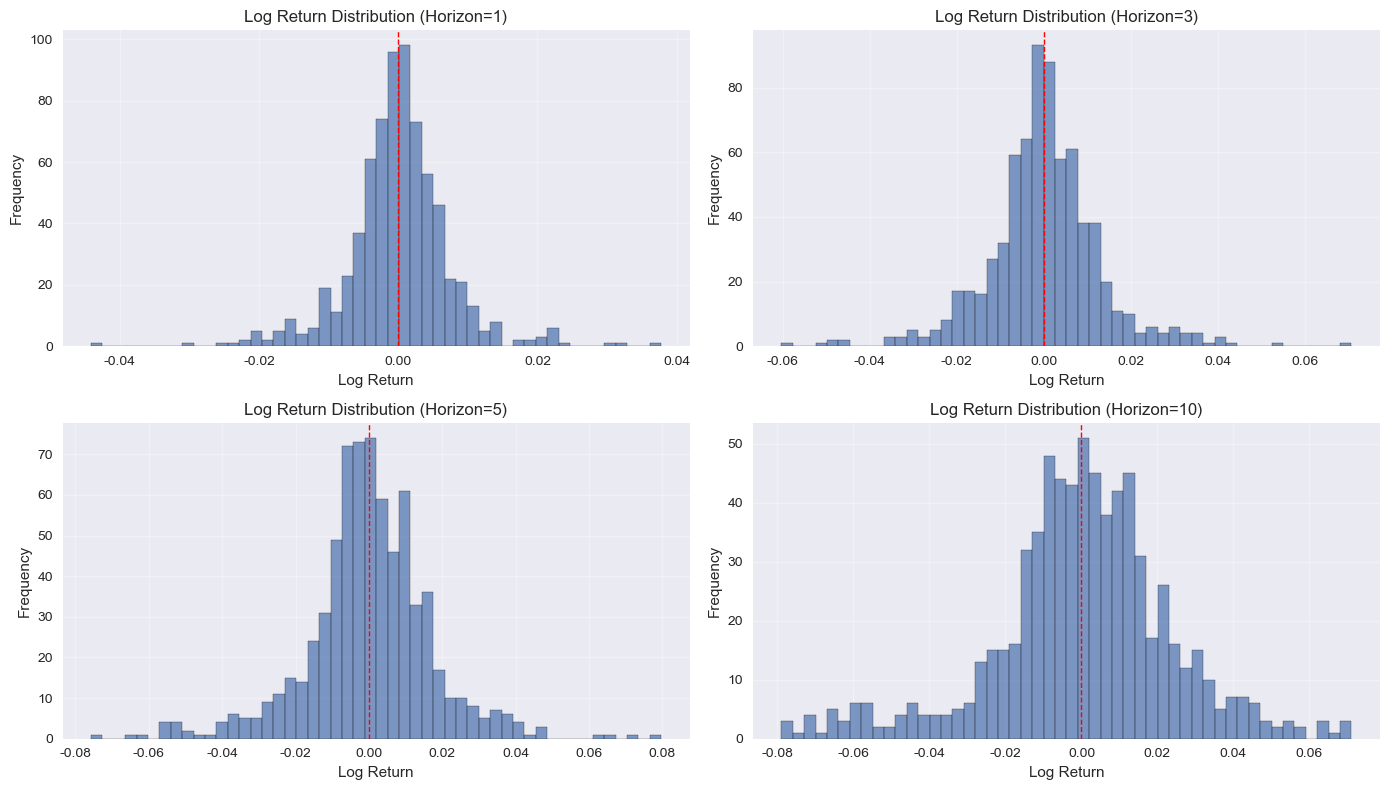

In [35]:
# 查看标签数据
print("标签数据前5行:")
display(y.head())

print(f"\n标签统计信息:")
display(y.describe())

# 可视化标签分布
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
for i, horizon in enumerate([1, 3, 5, 10]):
    ax = axes[i // 2, i % 2]
    col = f'log_return_{horizon}'
    if col in y.columns:
        y[col].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
        ax.set_title(f'Log Return Distribution (Horizon={horizon})')
        ax.set_xlabel('Log Return')
        ax.set_ylabel('Frequency')
        ax.axvline(0, color='red', linestyle='--', linewidth=1)
        ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [43]:
def winsorize_single_factor(series, quantiles=(0.01, 0.99)):
    if len(quantiles) != 2 or quantiles[0] >= quantiles[1]:
        raise ValueError("quantiles必须是(低分位, 高分位)，且低分位 < 高分位")
    
    if quantiles[0] < 0 or quantiles[1] > 1:
        raise ValueError("分位数必须在[0, 1]范围内")
    
    # 定义单组缩尾函数
    lower = series.quantile(quantiles[0])
    upper = series.quantile(quantiles[1])
    return  series.clip(lower=lower, upper=upper)

def rolling_z_score(series, rolling_window=30):
    mean_ = ta.MA(series,rolling_window)
    std_ = ta.STDDEV(series,rolling_window)
    return (series - mean_) / std_

def _robust_zscore(series: pd.Series, rolling_window=30, method='tanh', scale=3) -> pd.Series:
    """
    基于中位数与MAD的稳健z分数
    
    Parameters:
    -----------
    series : pd.Series
        输入数据序列
    rolling_window : int
        滚动窗口大小
    method : str
        截断方法: 'clip'(硬截断), 'tanh'(平滑), 'none'(不截断)
    scale : float
        tanh方法的缩放参数
    
    Returns:
    --------
    pd.Series
        标准化后的因子值
    """
    import numpy as np
    
    x = pd.to_numeric(series, errors='coerce')
    eps = 1e-9
    
    w = int(rolling_window)
    med_roll = x.rolling(window=w).median()
    mad_roll = (x - med_roll).abs().rolling(window=w).median()
    
    factor_res = 0.6745 * (x - med_roll) / (mad_roll + eps)
    
    # 根据方法选择截断方式
    if method == 'clip':
        result = factor_res.clip(-6, 6)
    elif method == 'tanh':
        result = pd.Series(scale * np.tanh(factor_res / scale), index=x.index)
    else:  # 'none'
        result = factor_res
    
    return result


def map_to_position(factor_series: pd.Series, winsorize_ratio=0.01, rolling_window=30):
    # 1. 缩尾处理（替代clip，保留梯度）
    upper = factor_series.quantile(1 - winsorize_ratio)
    lower = factor_series.quantile(winsorize_ratio)
    factor_winsorized = factor_series.clip(lower, upper)  # 仅截断极端异常值
    
    # 2. 线性缩放到[-1,1]
    min_val = factor_winsorized.min()
    max_val = factor_winsorized.max()
    if max_val == min_val:  # 避免除以0
        return pd.Series(0, index=factor_series.index)
    position = (factor_winsorized - min_val) / (max_val - min_val) * 2 - 1
    return position

def _expanding_zscore(x, ddof=1):
    # 这是相当于expanding z-score标准化，但是这里的标准差是用的无偏估计
    x = np.array(x)
    x = np.nan_to_num(x)
    x_cumsum = np.cumsum(x)
    x_squared_cumsum = np.cumsum(x ** 2)
    count = np.arange(1, len(x) + 1)
    x_mean = x_cumsum / count
    x_std = np.sqrt(((x_squared_cumsum - 2 * x_cumsum * x_mean) / count) + x_mean ** 2) * np.sqrt(
        count / (count - ddof))
    x_value = (x - x_mean) / x_std
    # clip的值，需要测算，没有在log_return 基础上乘1000
    x_value = np.clip(x_value, -6, 6)
    x_value = np.nan_to_num(x_value)

    return x_value

def expanding_zscore(series: pd.Series, eps: float = 1e-9) -> pd.Series:
    """
    计算序列的累积z-score标准化（expanding z-score）
    
    公式：z = (x - 累积均值) / 累积标准差
    其中，累积均值和累积标准差是从序列起始到当前位置的所有数据计算得到
    
    参数:
        series: 输入的pandas序列
        eps: 防止除以零的极小值，默认1e-9
        
    返回:
        pd.Series: 标准化后的序列，索引与输入一致
    """
    # 将序列转换为数值型，无法转换的值设为NaN
    x = pd.to_numeric(series, errors='coerce')
    
    # 计算累积均值（从第一个元素到当前元素的均值）
    expanding_mean = x.expanding().mean()
    
    # 计算累积标准差（使用N-1的无偏估计）
    expanding_std = x.expanding().std(ddof=1)  # ddof=1表示除以N-1
    
    # 计算z-score，加入eps避免除以零
    z_score = (x - expanding_mean) / (expanding_std + eps)
    
    return z_score


def _robust_zscore_tanh(series: pd.Series, rolling_window=30, scale=3):
    """Tanh平滑截断 - 计算效率高且效果好"""
    import numpy as np
    
    x = pd.to_numeric(series, errors='coerce')
    eps = 1e-9
    
    w = int(rolling_window)
    med_roll = x.rolling(window=w).median()
    mad_roll = (x - med_roll).abs().rolling(window=w).median()
    
    factor_res = 0.6745 * (x - med_roll) / (mad_roll + eps)
    
    # tanh平滑截断：在[-scale, scale]之间平滑过渡
    return scale * np.tanh(factor_res / scale)

def _robust_zscore_rankgauss(series: pd.Series, rolling_window=30):
    """简化的滚动 RankGauss"""
    from scipy.stats import norm
    import numpy as np
    
    x = pd.to_numeric(series, errors='coerce')
    w = int(rolling_window)
    
    # 计算滚动排名百分位
    def rolling_rank_pct(s):
        # 返回当前值在窗口内的百分位
        return (s.rank(pct=True).iloc[-1] if len(s) > 0 else 0.5)
    
    rank_pct = x.rolling(window=w, min_periods=1).apply(
        rolling_rank_pct, raw=False
    )
    
    # 映射到正态分布
    rank_pct_clipped = rank_pct.clip(0.01, 0.99)  # 避免极端值
    return pd.Series(norm.ppf(rank_pct_clipped), index=x.index)

X2_y_pd = pd.concat([X, y], axis=1)

In [31]:
X2_y_pd.head(5)

,large_q90_count,large_q90_dollar_sum,large_q90_avg_dollar,large_q90_max_dollar,large_q90_std_dollar,large_q90_participation_dollar,large_q90_buy_dollar_sum,large_q90_sell_dollar_sum,large_q90_taker_buy_count,large_q90_taker_sell_count,large_q90_imbalance_by_count,large_q90_imbalance_by_dollar,large_q90_signed_dollar_sum,large_q90_lti,large_q90_herfindahl_dollar,large_q90_top1_share_dollar,large_q90_top3_share_dollar,large_q90_arrival_intensity,large_q90_interarrival_mean,large_q90_interarrival_std,large_q90_runlen_buy_max,large_q90_runlen_sell_max,large_q90_burstiness,large_q90_sweep_count,large_q90_sweep_avg_size,large_q90_sweep_max_size,large_q95_count,large_q95_dollar_sum,large_q95_avg_dollar,large_q95_max_dollar,large_q95_std_dollar,large_q95_participation_dollar,large_q95_buy_dollar_sum,large_q95_sell_dollar_sum,large_q95_taker_buy_count,large_q95_taker_sell_count,large_q95_imbalance_by_count,large_q95_imbalance_by_dollar,large_q95_signed_dollar_sum,large_q95_lti,large_q95_herfindahl_dollar,large_q95_top1_share_dollar,large_q95_top3_share_dollar,large_q95_arrival_intensity,large_q95_interarrival_mean,large_q95_interarrival_std,large_q95_runlen_buy_max,large_q95_runlen_sell_max,large_q95_burstiness,large_q95_sweep_count,large_q95_sweep_avg_size,large_q95_sweep_max_size,feature_start,feature_end,prediction_time,log_return_1,t0_time_1,tH_time_1,log_return_2,t0_time_2,tH_time_2,log_return_3,t0_time_3,tH_time_3,log_return_4,t0_time_4,tH_time_4,log_return_5,t0_time_5,tH_time_5,log_return_6,t0_time_6,tH_time_6,log_return_7,t0_time_7,tH_time_7,log_return_8,t0_time_8,tH_time_8,log_return_9,t0_time_9,tH_time_9,log_return_10,t0_time_10,tH_time_10,log_return_11,t0_time_11,tH_time_11,log_return_12,t0_time_12,tH_time_12
bar_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24,249587,3.555239e+09,14244.487557,5665141.65,35236.998514,0.838647,1.710264e+09,1.844975e+09,123114,126473,-0.013458,-0.037891,-1.347114e+08,-0.037891,0.000029,0.001593,0.004747,2.888738,0.346145,1.068025,879,928,0.510462,24295,141299.297874,4.178425e+07,124793,2.906499e+09,23290.564700,5665141.65,48142.912912,0.685615,1.387164e+09,1.519335e+09,60858,63935,-0.024657,-0.045474,-1.321708e+08,-0.045474,0.000042,0.001949,0.005807,1.444363,0.692296,2.103168,373,440,0.504700,14754,184218.128289,2.862246e+07,2025-01-01 00:00:00,2025-01-02 00:00:00,2025-01-02 01:00:00,-0.001846,2025-01-02 01:00:00,2025-01-02 02:00:00,0.002543,2025-01-02 01:00:00,2025-01-02 03:00:00,-0.000372,2025-01-02 01:00:00,2025-01-02 04:00:00,0.008388,2025-01-02 01:00:00,2025-01-02 05:00:00,0.006828,2025-01-02 01:00:00,2025-01-02 06:00:00,0.006159,2025-01-02 01:00:00,2025-01-02 07:00:00,0.008938,2025-01-02 01:00:00,2025-01-02 08:00:00,0.014275,2025-01-02 01:00:00,2025-01-02 09:00:00,0.022935,2025-01-02 01:00:00,2025-01-02 10:00:00,0.023163,2025-01-02 01:00:00,2025-01-02 11:00:00,0.023707,2025-01-02 01:00:00,2025-01-02 12:00:00,0.026415,2025-01-02 01:00:00,2025-01-02 13:00:00
25,263705,3.756206e+09,14243.970177,5665141.65,33877.749357,0.835998,1.809109e+09,1.947097e+09,129365,134340,-0.018866,-0.036736,-1.379885e+08,-0.036736,0.000025,0.001508,0.004493,3.052141,0.327636,1.048915,361,928,0.523975,24477,148495.670817,4.173066e+07,131853,3.059082e+09,23200.701176,5665141.65,46184.526984,0.680843,1.465409e+09,1.593673e+09,64311,67542,-0.024505,-0.041929,-1.282645e+08,-0.041929,0.000038,0.001852,0.005517,1.526076,0.655272,2.047751,226,440,0.515156,15183,189075.040095,2.854703e+07,2025-01-01 01:00:00,2025-01-02 01:00:00,2025-01-02 02:00:00,0.004389,2025-01-02 02:00:00,2025-01-02 03:00:00,0.001474,2025-01-02 02:00:00,2025-01-02 04:00:00,0.010234,2025-01-02 02:00:00,2025-01-02 05:00:00,0.008673,2025-01-02 02:00:00,2025-01-02 06:00:00,0.008005,2025-01-02 02:00:00,2025-01-02 07:00:00,0.010784,2025-01-02 02:00:00,2025-01-02 08:00:00,0.016121,2025-01-02 02:00:00,2025-01-02 09:00:00,0.024780,2025-01-02 02:00:00,2025-01-02 10:00:00,0.025008,2025-01-02 02:00:00,2025-01-02 

In [54]:
# 要排除的列
exclude_cols = ['feature_start', 'feature_end', 'prediction_time']

# 筛选保留的列名（所有列 - 排除的列）
keep_cols = [col for col in X.columns if col not in exclude_cols]

# 选择保留的列
X_filtered = X[keep_cols]

X_filtered.columns

Index(['large_q90_count', 'large_q90_dollar_sum', 'large_q90_avg_dollar',
       'large_q90_max_dollar', 'large_q90_std_dollar',
       'large_q90_participation_dollar', 'large_q90_buy_dollar_sum',
       'large_q90_sell_dollar_sum', 'large_q90_taker_buy_count',
       'large_q90_taker_sell_count', 'large_q90_imbalance_by_count',
       'large_q90_imbalance_by_dollar', 'large_q90_signed_dollar_sum',
       'large_q90_lti', 'large_q90_herfindahl_dollar',
       'large_q90_top1_share_dollar', 'large_q90_top3_share_dollar',
       'large_q90_arrival_intensity', 'large_q90_interarrival_mean',
       'large_q90_interarrival_std', 'large_q90_runlen_buy_max',
       'large_q90_runlen_sell_max', 'large_q90_burstiness',
       'large_q90_sweep_count', 'large_q90_sweep_avg_size',
       'large_q90_sweep_max_size', 'large_q95_count', 'large_q95_dollar_sum',
       'large_q95_avg_dollar', 'large_q95_max_dollar', 'large_q95_std_dollar',
       'large_q95_participation_dollar', 'large_q95_buy_dollar

[0.024397845761994223, 0.021948411835088586, 0.02355189454849292, 0.012686048548206225, 0.0017556859693368427, -0.008857546820940951, -0.01605271204874524, -0.02230290255148905, -0.030628588363410997, -0.04016265227163628, -0.04782739626285956, -0.06000285440475856]


<Axes: >

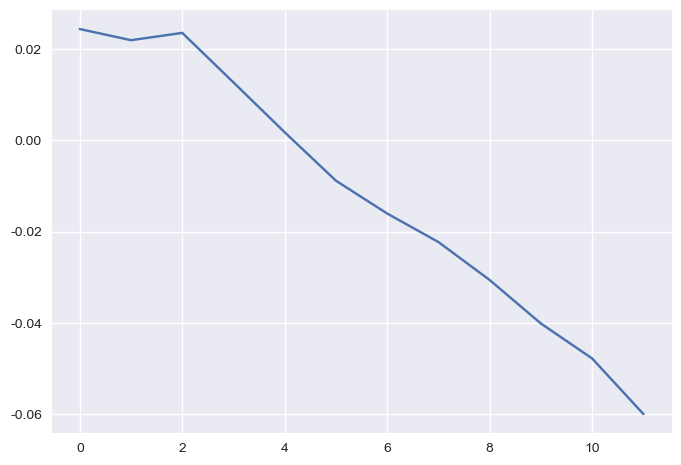

In [ ]:
# factor_name = 'large_q90_lti'

# def build_factor_corr(factor_name):
#     factor_series = X2_y_pd[f'{factor_name}']
#     # winsorize_value = _robust_zscore(factor_series)
#     winsorize_value = _robust_zscore(factor_series, method='clip')

#     corr_list = []
#     for horizon in horizon_bars:
#         corr_list.append(winsorize_value.corr(X2_y_pd[f'log_return_{horizon}']))
#     return winsorize_value, corr_list

# factor_robust_zscore, corr_list = build_factor_corr(factor_name)

# print(corr_list)
# factor_robust_zscore.hist(bins=100)
# pd.Series(corr_list).plot()


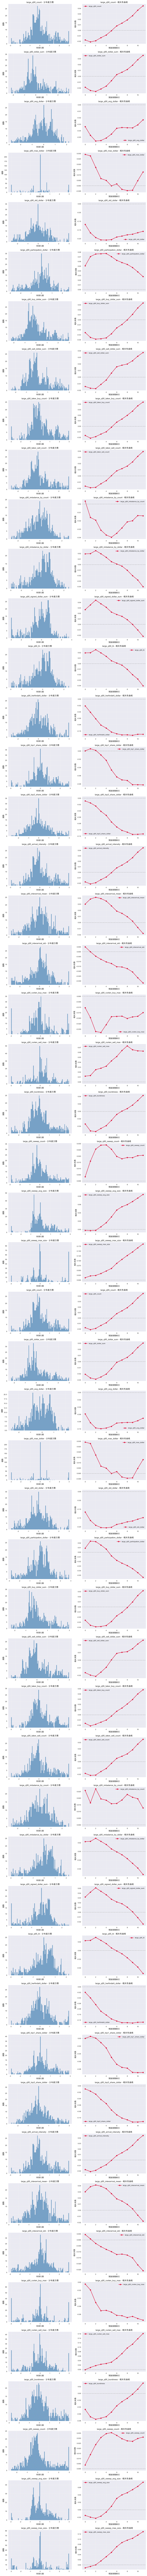


large_q90_count:
  平均相关性: 0.0057
  最大相关性: 0.0448
  相关性列表: [-0.01741770692743346, -0.021080688123856155, -0.01890068510725222, -0.013343679055587919, -0.008573265334426289, -0.0005407181412778363, 0.008160869126662366, 0.013180595585476964, 0.018993607381812123, 0.02672886867988652, 0.036784741374264525, 0.044753673961224455]

large_q90_dollar_sum:
  平均相关性: -0.0008
  最大相关性: 0.0358
  相关性列表: [-0.018656576438886702, -0.02416784394864633, -0.025811075789502334, -0.021474648009919967, -0.016771628195568905, -0.007487302238212725, 0.0029359221654249586, 0.00698048703856601, 0.011620578810478913, 0.018917085359927626, 0.028338533362855318, 0.03577085817657769]

large_q90_avg_dollar:
  平均相关性: -0.0403
  最大相关性: -0.0558
  相关性列表: [-0.03358874572618584, -0.04696654068395124, -0.05583955386771415, -0.055115635218003806, -0.051229183262323424, -0.04516327105102622, -0.03616652226527409, -0.03503568730896039, -0.0352954310009488, -0.03554443237420286, -0.03088434818221143, -0.023118055219997127]

larg

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def build_factor_corr_multi(factor_names, method='tanh', rolling_window=30):
    """
    分析多个因子的分布和相关性
    
    Parameters:
    -----------
    factor_names : list or str
        因子名称列表，或单个因子名称
    method : str
        标准化方法: 'clip', 'tanh', 'none'
    rolling_window : int
        滚动窗口大小
        
    Returns:
    --------
    dict : 包含每个因子的标准化值和相关性列表
    """
    # 支持单个因子名称
    if isinstance(factor_names, str):
        factor_names = [factor_names]
    
    results = {}
    
    # 计算每个因子
    for factor_name in factor_names:
        factor_series = X2_y_pd[f'{factor_name}']
        winsorize_value = _robust_zscore(
            factor_series, 
            rolling_window=rolling_window, 
            method=method
        )
        
        corr_list = []
        for horizon in horizon_bars:
            corr_list.append(
                winsorize_value.corr(X2_y_pd[f'log_return_{horizon}'])
            )
        
        results[factor_name] = {
            'zscore': winsorize_value,
            'corr_list': corr_list
        }
    
    return results


def plot_factor_analysis(results, figsize_per_factor=(12, 4)):
    """
    绘制因子分析图表
    
    Parameters:
    -----------
    results : dict
        build_factor_corr_multi 的返回结果
    figsize_per_factor : tuple
        每个因子的图表尺寸
    """
    n_factors = len(results)
    
    # 创建子图：每个因子2列（直方图 + 相关性曲线）
    fig, axes = plt.subplots(
        n_factors, 2, 
        figsize=(figsize_per_factor[0], figsize_per_factor[1] * n_factors)
    )
    
    # 如果只有一个因子，确保 axes 是二维数组
    if n_factors == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (factor_name, data) in enumerate(results.items()):
        # 左图：直方图
        axes[idx, 0].hist(data['zscore'].dropna(), bins=100, alpha=0.7, color='steelblue')
        axes[idx, 0].set_title(f'{factor_name} - 分布直方图', fontsize=12)
        axes[idx, 0].set_xlabel('标准化值')
        axes[idx, 0].set_ylabel('频数')
        axes[idx, 0].grid(alpha=0.3)
        
        # 右图：相关性曲线
        axes[idx, 1].plot(
            range(len(data['corr_list'])), 
            data['corr_list'], 
            marker='o', 
            linewidth=2,
            color='crimson',
            label=factor_name
        )
        axes[idx, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        axes[idx, 1].set_title(f'{factor_name} - 相关性曲线', fontsize=12)
        axes[idx, 1].set_xlabel('预测周期索引')
        axes[idx, 1].set_ylabel('相关系数')
        axes[idx, 1].grid(alpha=0.3)
        axes[idx, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig


# 使用示例
factor_names = ['large_q90_count', 'large_q90_dollar_sum', 'large_q90_avg_dollar','large_q90_max_dollar', 'large_q90_std_dollar','large_q90_participation_dollar', 'large_q90_buy_dollar_sum','large_q90_sell_dollar_sum', 'large_q90_taker_buy_count','large_q90_taker_sell_count', 'large_q90_imbalance_by_count','large_q90_imbalance_by_dollar', 'large_q90_signed_dollar_sum','large_q90_lti', 'large_q90_herfindahl_dollar','large_q90_top1_share_dollar', 'large_q90_top3_share_dollar','large_q90_arrival_intensity', 'large_q90_interarrival_mean','large_q90_interarrival_std', 'large_q90_runlen_buy_max','large_q90_runlen_sell_max', 'large_q90_burstiness','large_q90_sweep_count', 'large_q90_sweep_avg_size','large_q90_sweep_max_size', 'large_q95_count', 'large_q95_dollar_sum','large_q95_avg_dollar', 'large_q95_max_dollar', 'large_q95_std_dollar','large_q95_participation_dollar', 'large_q95_buy_dollar_sum','large_q95_sell_dollar_sum', 'large_q95_taker_buy_count','large_q95_taker_sell_count', 'large_q95_imbalance_by_count','large_q95_imbalance_by_dollar', 'large_q95_signed_dollar_sum','large_q95_lti', 'large_q95_herfindahl_dollar','large_q95_top1_share_dollar', 'large_q95_top3_share_dollar','large_q95_arrival_intensity', 'large_q95_interarrival_mean','large_q95_interarrival_std', 'large_q95_runlen_buy_max','large_q95_runlen_sell_max', 'large_q95_burstiness','large_q95_sweep_count', 'large_q95_sweep_avg_size','large_q95_sweep_max_size']

# 分析多个因子
results = build_factor_corr_multi(factor_names, method='tanh')

# 绘制分析图表
plot_factor_analysis(results)

# 打印相关性统计
for factor_name, data in results.items():
    print(f"\n{factor_name}:")
    print(f"  平均相关性: {np.mean(data['corr_list']):.4f}")
    print(f"  最大相关性: {max(data['corr_list'], key=abs):.4f}")
    print(f"  相关性列表: {data['corr_list']}")

In [50]:
# 训练模型并评估
results = pipeline.train_and_evaluate(
    X, y,
    model_type=model_type,
    target_horizon=target_horizon,
    n_splits=n_splits,
    embargo_bars=embargo_bars
)

print("\n✅ 模型训练与评估完成")


开始训练linear模型...
模型评估完成!
平均Pearson IC: 0.0472
平均Spearman IC: 0.0702
平均RMSE: 0.0245
平均方向准确率: 0.5014

✅ 模型训练与评估完成


In [17]:
# 查看详细的评估结果
summary = results['summary']

print("="*60)
print("模型评估结果")
print("="*60)
print(f"\n📊 预测能力指标:")
print(f"  Pearson IC (均值):  {summary['pearson_ic_mean']:.4f} (± {summary['pearson_ic_std']:.4f})")
print(f"  Spearman IC (均值): {summary['spearman_ic_mean']:.4f} (± {summary['spearman_ic_std']:.4f})")
print(f"  方向准确率 (均值):  {summary['dir_acc_mean']:.2%} (± {summary['dir_acc_std']:.2%})")

print(f"\n📉 误差指标:")
print(f"  RMSE (均值):        {summary['rmse_mean']:.6f} (± {summary['rmse_std']:.6f})")
print(f"  MAE (均值):         {summary['mae_mean']:.6f} (± {summary['mae_std']:.6f})")

print(f"\n💰 策略收益指标:")
print(f"  夏普比率 (均值):    {summary['sharpe_net_mean']:.4f} (± {summary['sharpe_net_std']:.4f})")

print(f"\n🔢 交叉验证信息:")
print(f"  有效折数:           {summary['n_splits_effective']}/{n_splits}")

print("="*60)


模型评估结果

📊 预测能力指标:


KeyError: 'pearson_ic_std'

In [ ]:
# 查看各折的详细结果
fold_results = results['fold_results']

print("\n各折详细结果:")
fold_df = pd.DataFrame([
    {
        'Fold': i+1,
        'Pearson_IC': fold['pearson_ic'],
        'Spearman_IC': fold['spearman_ic'],
        'Dir_Acc': fold['dir_acc'],
        'RMSE': fold['rmse'],
        'Sharpe': fold['sharpe_net'],
        'Train_Size': fold['train_size'],
        'Test_Size': fold['test_size']
    }
    for i, fold in enumerate(fold_results)
])

display(fold_df)


In [ ]:
# 使用 Pipeline 的可视化方法
pipeline.visualize_results(save_dir=plot_save_dir)
print(f"✅ 可视化结果已保存到: {plot_save_dir}")


In [ ]:
# # 额外的可视化：预测值 vs 真实值散点图
# predictions = results['predictions']
# target_col = f'log_return_{target_horizon}'
# y_true = y[target_col].loc[predictions.index]

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # 散点图
# axes[0].scatter(y_true, predictions, alpha=0.3, s=10)
# axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
#              'r--', linewidth=2, label='Perfect Prediction')
# axes[0].set_xlabel('True Log Return')
# axes[0].set_ylabel('Predicted Log Return')
# axes[0].set_title('Predictions vs Truth (Scatter)')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # 时间序列对比
# sample_size = min(500, len(predictions))
# sample_idx = predictions.index[:sample_size]
# axes[1].plot(range(sample_size), y_true.loc[sample_idx].values, 
#              label='True', alpha=0.7, linewidth=1)
# axes[1].plot(range(sample_size), predictions.loc[sample_idx].values, 
#              label='Predicted', alpha=0.7, linewidth=1)
# axes[1].set_xlabel('Sample Index')
# axes[1].set_ylabel('Log Return')
# axes[1].set_title(f'Predictions vs Truth (Time Series, first {sample_size} samples)')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


In [ ]:
# 特征重要性分析
if hasattr(pipeline.model, 'get_feature_importance'):
    importance = pipeline.model.get_feature_importance()
    importance_df = pd.DataFrame([
        {'Feature': k, 'Importance': v}
        for k, v in importance.items()
    ]).sort_values('Importance', ascending=False)
    
    print("\n前20个重要特征:")
    display(importance_df.head(20))
    
    # 可视化前15个特征
    top_n = 15
    top_features = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), top_features['Importance'].values)
    plt.yticks(range(top_n), top_features['Feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("当前模型不支持特征重要性分析")


In [ ]:
# 汇总结果
final_results = {
    'config': {
        'bar_type': bar_type,
        'time_interval': time_interval if bar_type == 'time' else None,
        'dollar_threshold': dollar_threshold if bar_type == 'dollar' else None,
        'feature_window_bars': feature_window_bars,
        'model_type': model_type,
        'target_horizon': target_horizon,
        'date_range': (start_date, end_date),
    },
    'data_stats': {
        'n_trades': len(trades_df),
        'n_bars': len(bars),
        'n_samples': len(X),
        'n_features': len(X.columns),
    },
    'evaluation': results['summary'],
}

print("\n" + "="*60)
print("完整结果摘要")
print("="*60)
print(f"\n📅 配置信息:")
print(f"  日期范围: {start_date} ~ {end_date}")
print(f"  Bar类型: {bar_type.upper()}")
if bar_type == 'time':
    print(f"  时间间隔: {time_interval}")
else:
    print(f"  Dollar阈值: {dollar_threshold:,}")
print(f"  特征窗口: {feature_window_bars} bars")
print(f"  模型类型: {model_type}")
print(f"  目标预测期: {target_horizon} bars")

print(f"\n📊 数据统计:")
print(f"  交易记录数: {len(trades_df):,}")
print(f"  Bar数量: {len(bars):,}")
print(f"  样本数量: {len(X):,}")
print(f"  特征数量: {len(X.columns)}")

print(f"\n🎯 模型表现:")
print(f"  Pearson IC:  {summary['pearson_ic_mean']:.4f} (± {summary['pearson_ic_std']:.4f})")
print(f"  Spearman IC: {summary['spearman_ic_mean']:.4f} (± {summary['spearman_ic_std']:.4f})")
print(f"  方向准确率:  {summary['dir_acc_mean']:.2%} (± {summary['dir_acc_std']:.2%})")
print(f"  夏普比率:    {summary['sharpe_net_mean']:.4f} (± {summary['sharpe_net_std']:.4f})")

print("="*60)
print("\n✅ 所有分析步骤完成！")


In [ ]:
# （可选）保存结果到文件
save_results = False  # 设置为 True 以保存结果

if save_results:
    output_dir = f'{base_path}/pipeline_results'
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存预测结果
    predictions_df = pd.DataFrame({
        'bar_id': predictions.index,
        'prediction': predictions.values,
        'true_value': y_true.values,
    })
    predictions_df.to_csv(f'{output_dir}/predictions.csv', index=False)
    
    # 保存特征数据
    X.to_csv(f'{output_dir}/features.csv')
    
    # 保存标签数据
    y.to_csv(f'{output_dir}/labels.csv')
    
    # 保存bars
    bars.to_csv(f'{output_dir}/bars.csv', index=False)
    
    # 保存评估结果
    import json
    with open(f'{output_dir}/evaluation_summary.json', 'w') as f:
        # 转换 numpy 类型为 Python 原生类型
        summary_json = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                       for k, v in summary.items()}
        json.dump(summary_json, f, indent=2)
    
    print(f"✅ 结果已保存到: {output_dir}")
else:
    print("💡 如需保存结果，请设置 save_results = True")
